**CSC 550 Final Project by Bianca Toto**

**Image Segmentation with Deep Learning**

This project utilizes the pretrained keras VGG-16 model to implement the Fully-Convolutional Network for image segmentation. The accuracy and loss are evaluated.

**Project Overview**

Implementation of the FCN-8 uses TensorFlow, NumPy, and SciPy libraries. The dataset used for this project is the Oxford-IIT Pet Dataset creaked by Parkhi *et al*. It is composed of images, with corresponding labels and pixel-wise masks that are labels for each pixel.

There are three pixel categories:

Class 1: Pixel belonging to pet

Class 2: Pixel bordering the pet

Class 3: None of the above/ Surrounding pixel

**Research Questions:**

**1.   What is Image Segmentation?**

Image segmentation trains a neural network to output a pixel-wise mask of the image to give a lower level understanding of the image.

**2. What is Fully Convolutional Network-based segmentation?**

FCN segmentation is an approach that maps from pixels to pixels without extracting region proposals. FCNs utilize convolutional and pooling layers to make low resolution predictions.

**FCN Architecture**

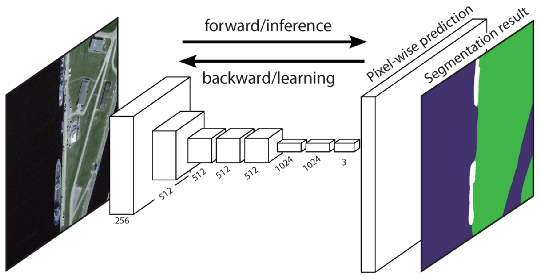

**FCN Architecture Description**



*   The FCN transfers the knowledge of VGG16 for the segmentation process.

*   1x1 convolution is used to converted the connected layers of VGG16 to convolutional layers to create a class presence heat map.

*   The low resolution maps are upsampled with transposed convolutions. To refine further, features are added from coarser, higher resolution maps from VGG16 lower layers.
*   After each convolution is skip connection. This extracts more abstract features.

**FCN-8 Architecture**

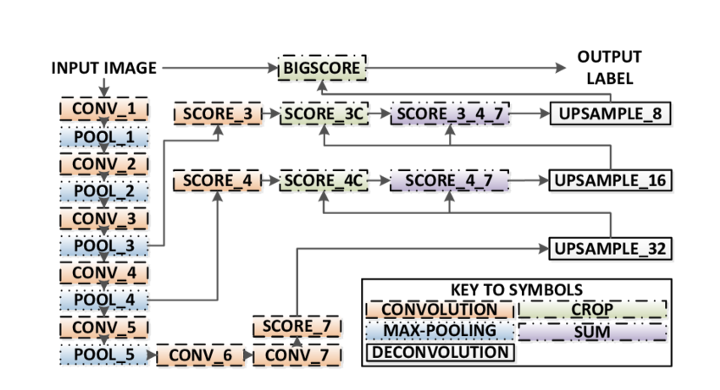

**FCN-8**

Encoder: A pre-trained VGG16 is used as an encoder. 

Decoder: starts from Layer 7 of VGG16.

FCN Layer-8: The last fully connected layer of VGG16 is replaced by a 1x1 convolution.

FCN Layer-9: FCN Layer-8 is upsampled 2 times to match dimensions with Layer 4 of VGG 16, using transposed convolution with parameters: (kernel=(4,4), stride=(2,2), paddding=’same’). After that, a skip connection was added between Layer 4 of VGG16 and FCN Layer-9.


FCN Layer-10: FCN Layer-9 is upsampled 2 times to match dimensions with Layer 3 of VGG16, using transposed convolution with parameters: (kernel=(4,4), stride=(2,2), paddding=’same’). After that, a skip connection was added between Layer 3 of VGG 16 and FCN Layer-10.


FCN Layer-11: FCN Layer-10 is upsampled 4 times to match dimensions with input image size so we get the actual image back and depth is equal to number of classes, using transposed convolution with parameters:(kernel=(16,16), stride=(8,8), paddding=’same’).


In [1]:
pip install -q git+https://github.com/tensorflow/examples.git 

In [2]:
#imports
import tensorflow as tf
import numpy  as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import models
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *


In [3]:
#download dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3T4W60/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3T4W60/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
#flip image, normalize, pixels labeled {0, 1, 2}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) 
  input_mask -= 1
  return input_image, input_mask

In [5]:
#load training image
def load_train_image(point):
  input_image = tf.image.resize(point['image'], (224, 224))
  input_mask = tf.image.resize(point['segmentation_mask'], (224, 224))
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
#load testing image
def load_test_image(point):
  input_image = tf.image.resize(point['image'], (224, 224))
  input_mask = tf.image.resize(point['segmentation_mask'], (224, 224))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [19]:
#split test and train data
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
#three possible labels so three channels
classes = 3
EPOCHS = 20
#learning_rate = 0.001
#keep_prob = 0.5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [8]:
train = dataset['train'].map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_image)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

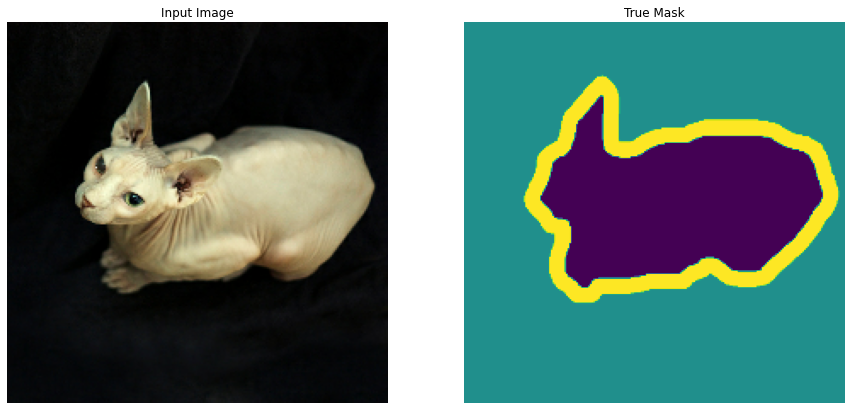

In [9]:
#looking at example
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [10]:
def build(num_classes=3, height=224, width=224, isTrain=True, weights='imagenet'):
    image_input = Input(shape=(height, width, 3))

    # Layer 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(image_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Layer2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Layer3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)
    pool3 = x

    # Layer4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
    pool4 = x

    # Layer5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
    pool5 = x

    x = Flatten(name='fatten')(x)
    x = Dense(4096, activation='relu', name='fc6')(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)

    vgg = Model(image_input, x)
    #vgg.load_weights('imagenet')

    conv_pool5 = Conv2D(4096, (7, 7), activation='relu', padding='same')(pool5)
    if isTrain:
        conv_pool5 = Dropout(0.5)(conv_pool5)
    conv_pool5 = Conv2D(4096, (1, 1), activation='relu', padding='same')(conv_pool5)
    if isTrain:
        conv_pool5 = Dropout(0.5)(conv_pool5)

    conv_pool5 = Conv2D(num_classes, (1, 1), kernel_initializer='he_normal')(conv_pool5)
    conv_pool5 = Conv2DTranspose(num_classes, kernel_size=(8, 8), strides=(4, 4), padding='same', use_bias=False)(conv_pool5)
    print('conv_pool5', conv_pool5)

    conv_pool4 = Conv2D(num_classes, (1, 1), kernel_initializer='he_normal')(pool4)
    conv_pool4 = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)(conv_pool4)
    print('conv_pool4', conv_pool4)

    conv_pool3 = Conv2D(num_classes, (1, 1), kernel_initializer='he_normal')(pool3)
    print('conv_pool3', conv_pool3)

    conv_x = Add()([conv_pool3, conv_pool4, conv_pool5])

    conv_x = Conv2DTranspose(num_classes, kernel_size=(16, 16), strides=(8, 8), padding='same', use_bias=False)(conv_x)
    print('conv_x', conv_x)
    #out = Reshape((-1, num_classes))(conv_x)
    #print('out', out)
    out = Activation('softmax')(conv_x)
    model = Model(image_input, out)

    return model

conv_pool5 KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), name='conv2d_transpose/conv2d_transpose:0', description="created by layer 'conv2d_transpose'")
conv_pool4 KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), name='conv2d_transpose_1/conv2d_transpose:0', description="created by layer 'conv2d_transpose_1'")
conv_pool3 KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), name='conv2d_4/BiasAdd:0', description="created by layer 'conv2d_4'")
conv_x KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), name='conv2d_transpose_2/conv2d_transpose:0', description="created by layer 'conv2d_transpose_2'")


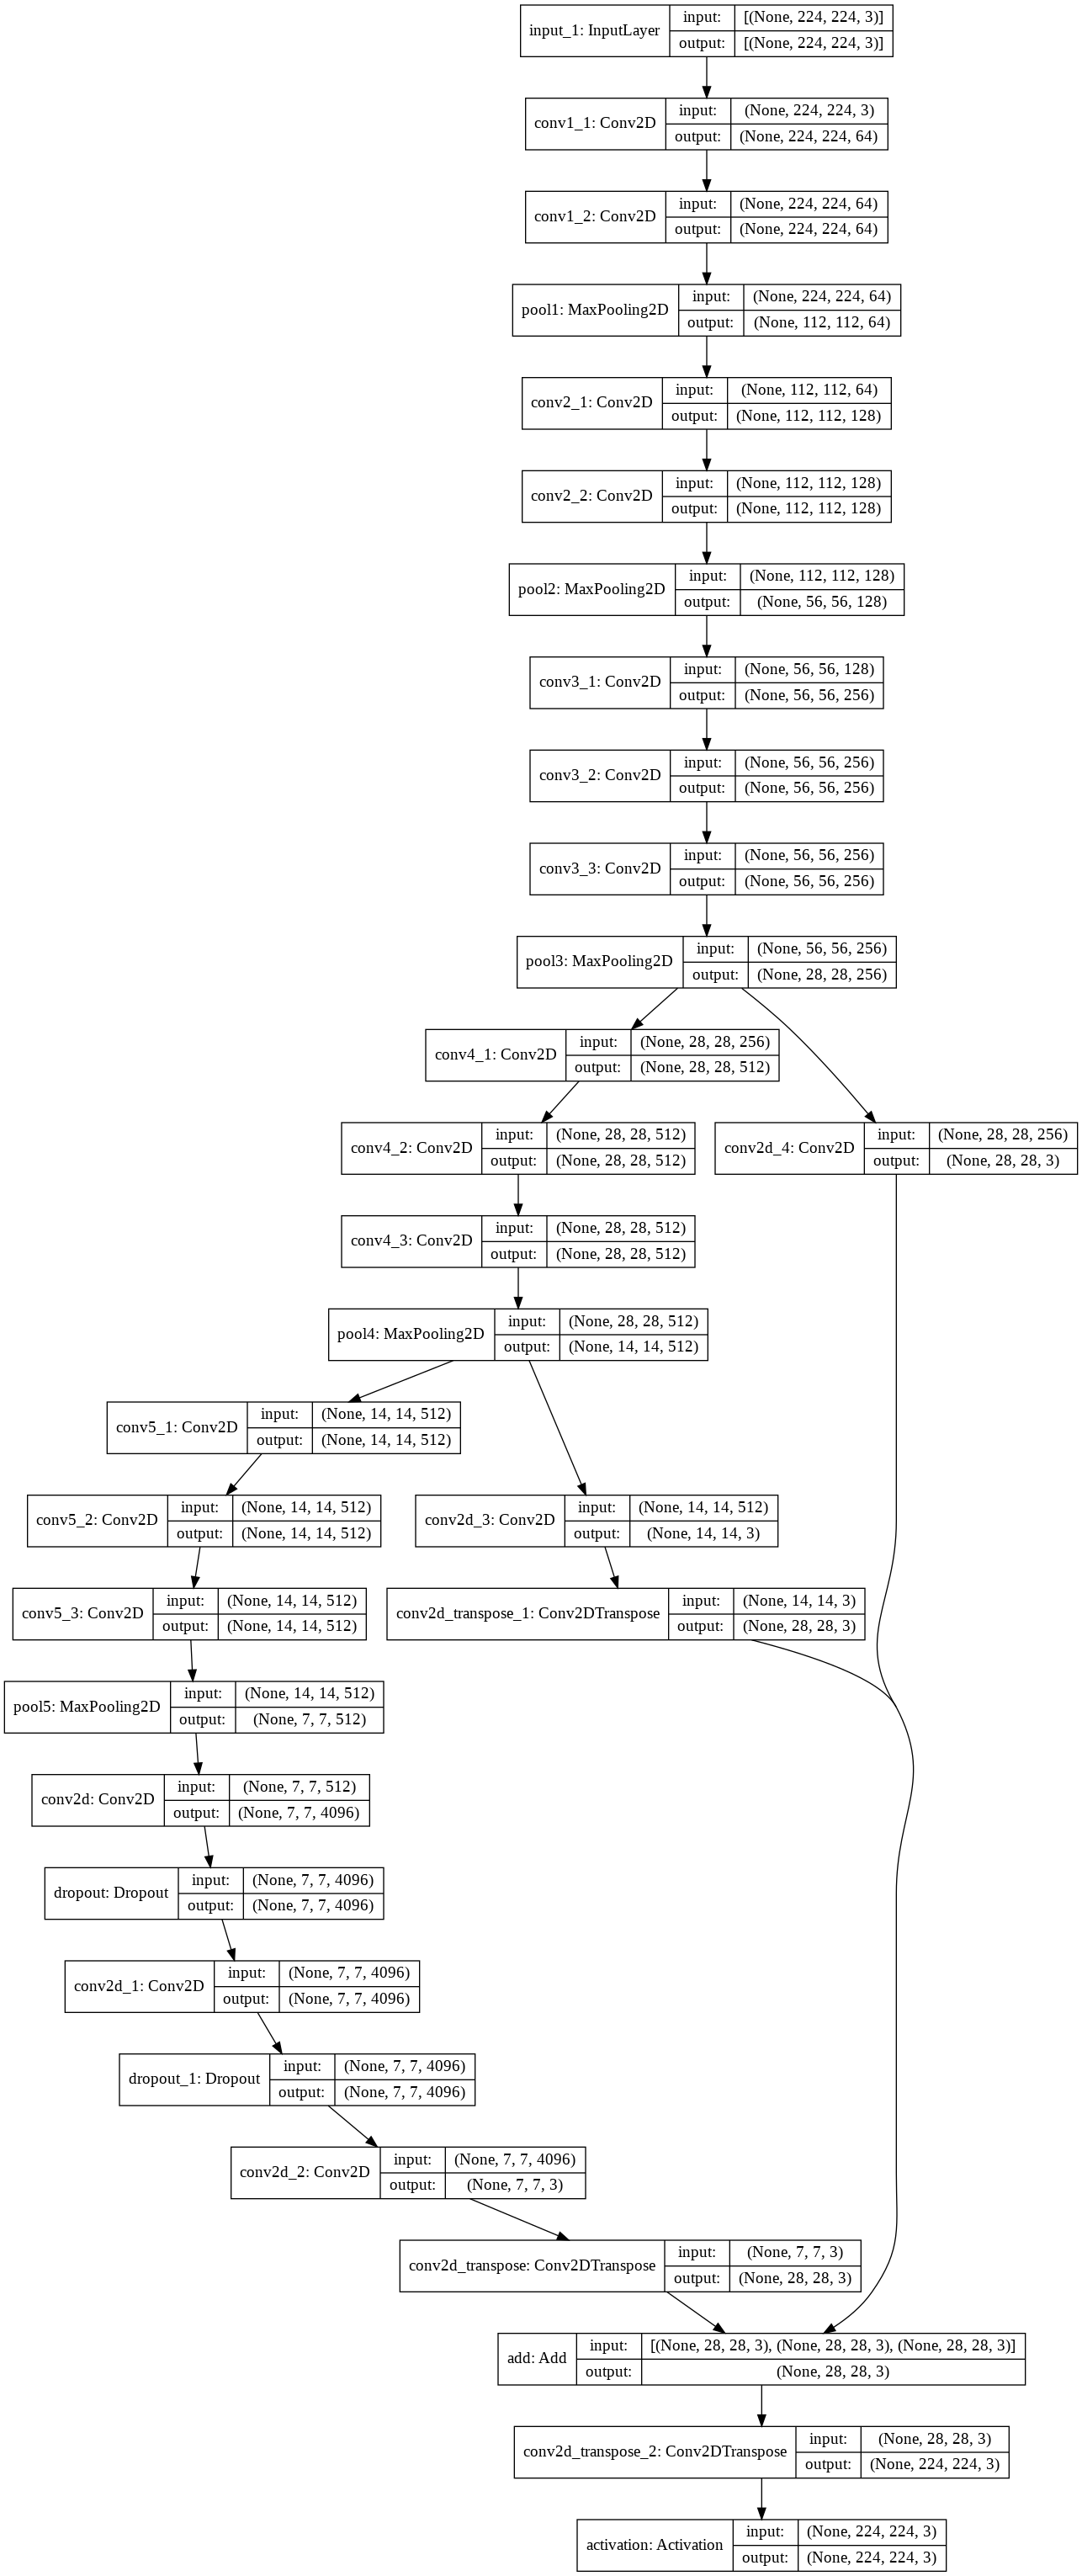

In [11]:
practicemodel = build()
practicemodel.compile(optimizer = 'adam',
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                      metrics = ['accuracy'])

tf.keras.utils.plot_model(practicemodel, show_shapes=True)

In [12]:
practicemodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

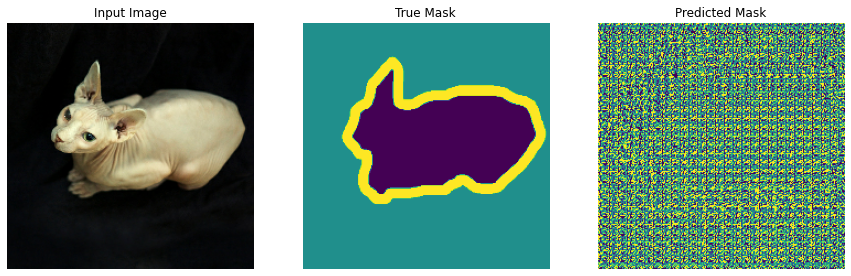

In [13]:
#predictions before training
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = practicemodel.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(practicemodel.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [14]:
#observe how model improves while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

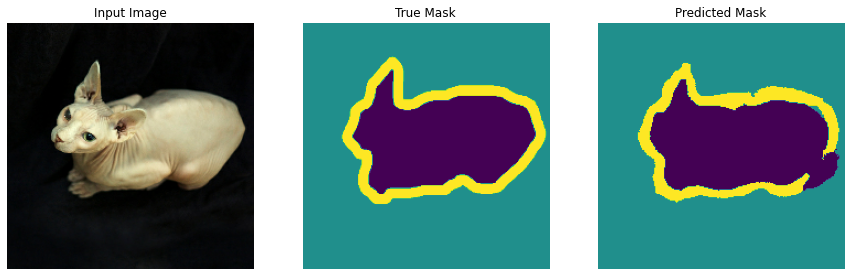


Sample Prediction after epoch 20



In [20]:
#training
model_history = practicemodel.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

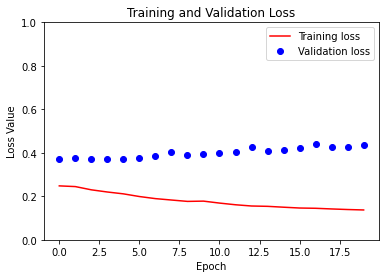

In [21]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

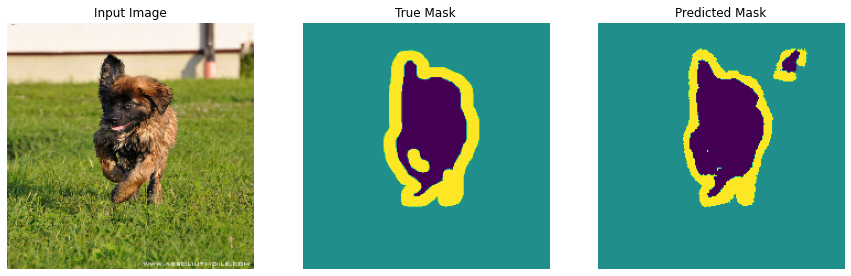

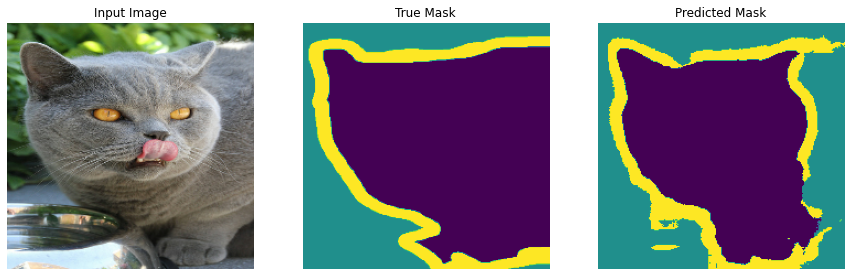

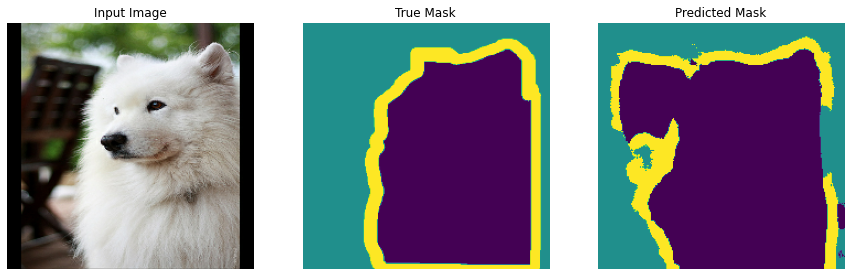

In [22]:
show_predictions(test_dataset, 3)